In [50]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load positive and negative training data from disk (images saved as arrays during preprocessing)

In [52]:
with open("cache/training/waldo.pkl", "rb") as f:
    pos_waldo = pickle.load(f)
with open("cache/training/wenda.pkl", "rb") as f:
    pos_wenda = pickle.load(f)
with open("cache/training/wizard.pkl", "rb") as f:
    pos_wizard = pickle.load(f)
with open("cache/training/neg_samples.pkl", "rb") as f:
    neg_samples = pickle.load(f)

# Training cascade classifier

### Generate .dat file describing positive samples and save positive samples as actual .jpg files

In [53]:
# example entry in .dat file: img/img1.jpg  1  140 100 45 45

with open('cache/training/waldo.info', 'w') as f:
    for idx, img in enumerate(pos_waldo):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/waldo_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/waldo_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

with open('cache/training/wenda.info', 'w') as f:
    for idx, img in enumerate(pos_wenda):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/wenda_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/wenda_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

with open('cache/training/wizard.info', 'w') as f:
    for idx, img in enumerate(pos_wizard):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/pos/wizard_{}.jpg'.format(idx), image_rgb)
        f.write('{} {} {} {} {} {}\n'.format('pos/wizard_{}.jpg'.format(idx), 1, 0, 0, img.shape[1], img.shape[0]))

### Generate bg.txt file describing negative samples and save negative samples as actual .jpg files

In [54]:
with open('cache/training/bg.txt', 'w') as f:
    for idx, img in enumerate(neg_samples):
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('cache/training/neg/negative_{}.jpg'.format(idx), image_rgb)
        f.write('neg/negative_{}.jpg\n'.format(idx))

### Generate .vec file for positive Waldo samples

In [55]:
# run this as shell commands:
# !opencv_createsamples -info waldo.info -num 124 -w 128 -h 128 -vec waldo.vec

### Train classifier using command line

In [56]:
# data1 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 124 -numNeg 250 -numStages 5
#  -precalcValBufSize 6144 -precalcIdxBufSize 6144 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 128 -h 128 
#  -weightTrimRate 0.95 -maxDepth 1

# data2 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 115 -numNeg 250 -numStages 10
#  -precalcValBufSize 7000 -precalcIdxBufSize 7000 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 128 -h 128 
#  -weightTrimRate 0.95 -maxDepth 1

# data3 waldo classifier trained via following command
# opencv_traincascade -data data -vec waldo.vec -bg bg.txt -numPos 124 -numNeg 250 -numStages 10
#  -precalcValBufSize 7000 -precalcIdxBufSize 7000 -acceptanceRatioBreakValue 10e-5 -featureType LBP -w 48 -h 48 
#  -weightTrimRate 0.95 -maxDepth 1

# Test classifier

### Load test data from disk and save test images as .jpg

In [57]:
with open("cache/testing/waldo.pkl", "rb") as f:
    waldo_test = pickle.load(f)
    
with open("cache/testing/neg_samples.pkl", "rb") as f:
    neg_test = pickle.load(f)

# The following generates perfectly cropped positive Waldos only
for idx, img in enumerate(waldo_test):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('cache/testing/pos/waldo_{}.jpg'.format(idx), image_rgb)
    
# The following generates 128x128 negatives only
for idx, img in enumerate(neg_test):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('cache/testing/neg/negative_{}.jpg'.format(idx), image_rgb)

In [71]:
cascPath = 'cache/training/data_2/cascade.xml'

waldoCascade = cv2.CascadeClassifier(cascPath)

def find_waldo(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    waldos = waldoCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=0, # should be like ~5 but currently there's no frame around a true sample so it must be 0
        minSize=(128, 128),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return waldos

### Run classifier on ground truth positive test images (scaled to exact fit dimensions of classifier)

/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


test data: 5 TP. 8 FN.


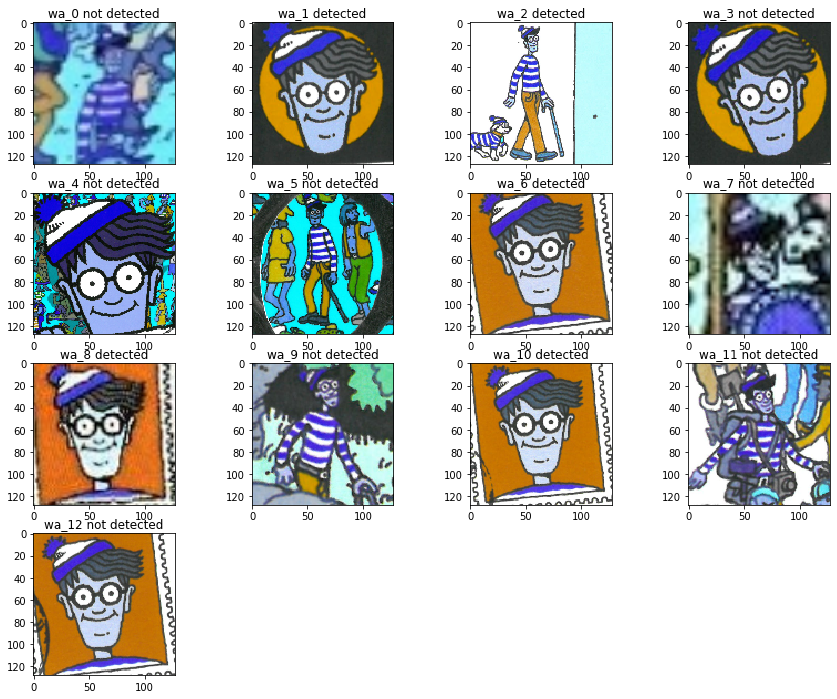

In [72]:
waldo_test_bbbs = []
not_detected = 0

for idx, img in enumerate(waldo_test[:16]):
    waldo_bb = find_waldo(img)
    waldo_test_bbbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if waldo_bb == ():
        plt.title('wa_{} not detected'.format(idx))
        not_detected += 1
    else:
        plt.title('wa_{} detected'.format(idx))

print("test data: {} TP. {} FN.".format(len(waldo_test_bbbs)-not_detected, not_detected))
plt.show()

### Run classifier on ground truth positive test images (scaled to exact fit dimensions of classifier)

/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


train data: 9 TP. 7 FN.


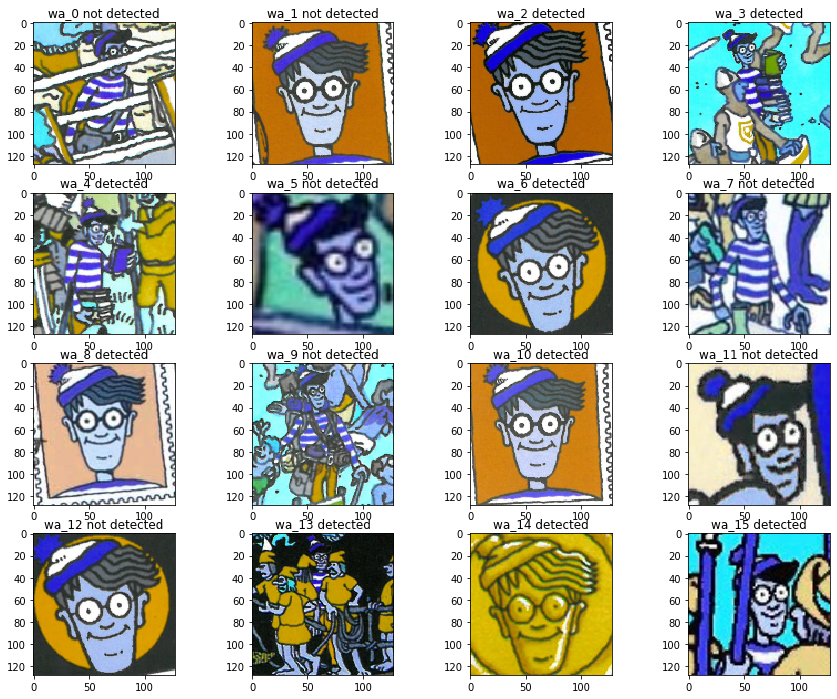

In [73]:
waldo_train_bbs = []
not_detected = 0

for idx, img in enumerate(pos_waldo[:16]):
    waldo_bb = find_waldo(img)
    waldo_train_bbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if waldo_bb == ():
        plt.title('wa_{} not detected'.format(idx))
        not_detected += 1
    else:
        plt.title('wa_{} detected'.format(idx))

print("train data: {} TP. {} FN.".format(len(waldo_train_bbs)-not_detected, not_detected))
plt.show()

### Run classifier on ground truth negative test images (scaled to exact fit dimensions of classifier)

test data: 0 FP. 16 TN.


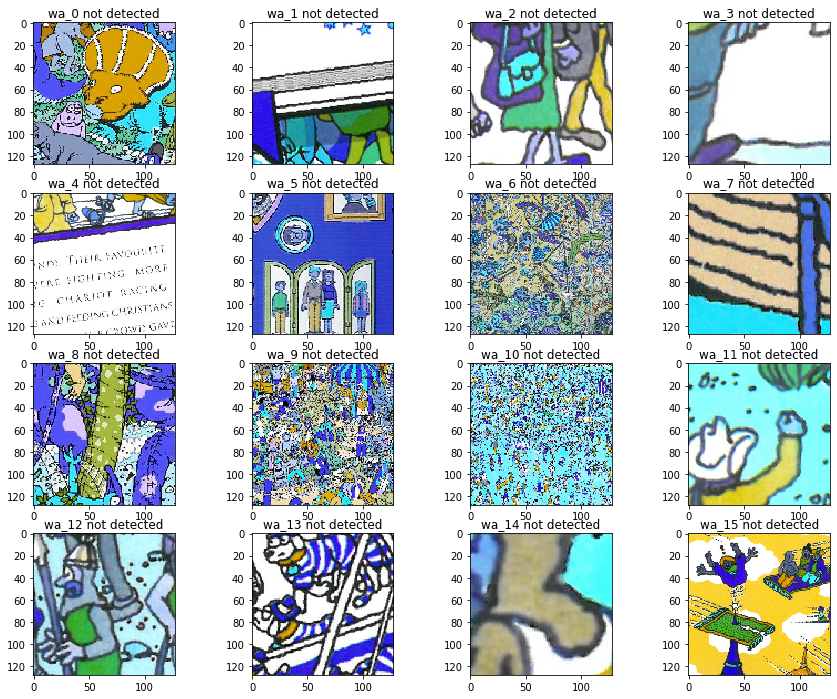

In [74]:
negative_test_bbs = []
not_detected = 0

for idx, img in enumerate(neg_test[:16]):
    waldo_bb = find_waldo(img)
    negative_test_bbs.append(waldo_bb)
    
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if waldo_bb == ():
        plt.title('wa_{} not detected'.format(idx))
        not_detected += 1
    else:
        plt.title('wa_{} detected'.format(idx))

print("test data: {} FP. {} TN.".format(len(negative_test_bbs)-not_detected, not_detected))
plt.show()

### Check evaluation time of Waldo classifier for all negatives

In [75]:
import time

print("amount of true negative samples: {}\n".format(len(neg_test)))
not_detected = 0
start_time = time.time()

for idx, img in enumerate(neg_test):
    if find_waldo(img) == ():
        not_detected += 1
print("test data: {} FP. {} TN.".format(len(neg_test)-not_detected, not_detected))
print("calculation took {} ms.".format(int(round((time.time()-start_time)*1000))))

amount of true negative samples: 2930



/Users/daviddrews/anaconda3/envs/CS4243/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


test data: 61 FP. 2869 TN.
calculation took 802 ms.


### Visualise cascade classifiers using command line

In [63]:
# !opencv_visualisation --image=/cache/testing/pos/waldo_0.jpg --model=/cache/training/data_1/cascade.xml --data=/cache/training/visualisation